# Purpose
The purpose of this notebook is to determine a plausible scaling factor for computed edge weights in the Riyadh Multiplex Metro project. It loads data, computes shortest paths, and compares those path lengths to Google's travel times. It then computes four plausible estimates of the scaling factor, averaged over all OD-pairs.

1. Ratio of means 
2. Mean of ratios
3. Ratio of trimmed means
4. Trimmed mean of ratios

Overall, PC suggests something close to 3., which gives a scaling factor of approximately 1.51. 

## Imports

In [1]:
% matplotlib inline
from metro import io
from metro import utility
from metro import assignment
import networkx as nx
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats.mstats import tmean

## Read in multiplex and OD matrix

In [2]:
multi = io.read_multi(nodes_file_name = '2_multiplex/multiplex_nodes.txt', 
                      edges_file_name = '2_multiplex/multiplex_edges.txt')
g = utility.nx_2_igraph(multi.layers_as_subgraph(['streets', 'taz']))
od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt', pivot = False)

computing od dictionary
OD dict computed in 0.4 m


## Construct node label lookup

The igraph network has integer node labels. We need a dict to convert them into the labels by which they are referred in the google data set. 

In [3]:
google_lookup = {v.index : int(v['google_name']) for v in g.vs if v['layer'] == 'taz'}
od['o_goog'] = od['o'].map(google_lookup.get)
od['d_goog'] = od['d'].map(google_lookup.get)

## Compute shortest paths

We define a quick convenience function to compute shortest paths between nodes using igraph. We can then compute those paths and add them to each OD pair in od. 

In [4]:
def get_paths(g, nodes, measure):
    target = nodes
    source = nodes
    lengths = g.shortest_paths_dijkstra(weights = measure, source = source, target = target)
    return lengths

In [5]:
weights = ['free_flow_time_m', 'congested_time_m', 'dist_km']
nodes = np.array([v.index for v in g.vs if v['layer'] == 'taz'])

for weight in weights: 
    p = get_paths(g, nodes, weight)
    q = [(nodes[i],nodes[j],p[i][j]) for i in range(len(nodes)) for j in range(len(nodes))]

    o = [tup[0] for tup in q]
    d = [tup[1] for tup in q]
    p = [tup[2] for tup in q]
    lengths = pd.DataFrame({'o' : o, 'd' : d, weight + '_length' : p})
    od = od.merge(lengths)

## Read the Google data and merge with the OD data

In [6]:
google = pd.read_table('1_data/google_times.txt')
od = od.merge(google, left_on = ['o_goog', 'd_goog'], right_on = ['Origin', 'Destination'])

/Users/phil/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (3,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean up

In [8]:
od = od[np.isnan(od['Expected (s)']) == False]
od['google_time_m'] = od['Expected (s)'] / 60

## Define basic variables for analysis

In [9]:
x = od['congested_time_m_length']
y = od['google_time_m']
z = y/x

## Simple bivariate plot

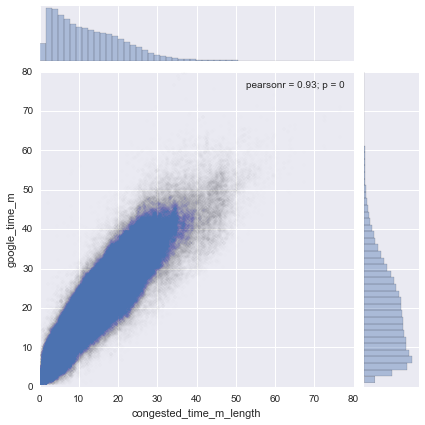

In [17]:
sns.jointplot(x, y, alpha = .005, xlim = (0,80), ylim = (0,80)) # Ok, looks sane! 

## Quick check on the distribution of the ratio

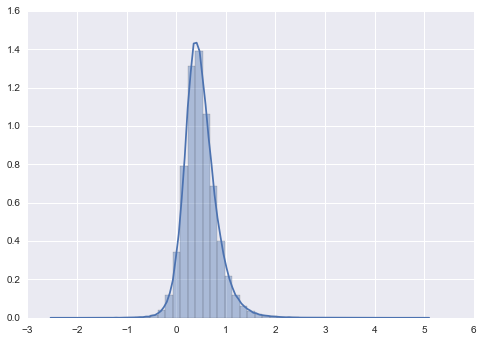

In [11]:
sns.distplot(np.log(z)) # ratio looks roughly lognormal

## Compute ratio of means and mean of ratios

In [12]:
print 'Ratio of means: ' + str(round(y.mean()/x.mean(), 2))
print 'Mean of ratios: ' + str(round(z.mean(), 2))

Ratio of means: 1.47
Mean of ratios: 1.74


## Compute ratio of trimmed means and mean of trimmed ratios

In [13]:
trim = .05

t1 = tmean(y, limits = (y.quantile(trim), y.quantile(1-trim)))
t2 = tmean(x, limits = (x.quantile(trim), x.quantile(1-trim)))
t3 = t1 / t2
t4 = tmean(z, limits = (z.quantile(trim), z.quantile(1-trim)))

print 'Ratio of trimmed means: ' + str(round(t3,2)) # PC would probably suggest something like this one
print 'Trimmed mean of ratios: ' + str(round(t4,2))

Ratio of trimmed means: 1.51
Trimmed mean of ratios: 1.66


PC would probably go for the ratio of trimmed means, since this is relatively robust to outliers and doesn't fall into any of the standard issues associated with means of ratios. 